# Neural-based channel decoders


## 1. Prerequisites:  

The purpose of this part of the work is to compare the BER of both a pre-trained neural decoder and the MAP decoder for a Polar code over an AWGN channel. 

In order to develop a neural based channel decoder you will need: 

- A communication chain which implements the polar code and its MAP decoder (under python)
- A working keras environment with the proper backend Tensorflow 


## 2. Training dataset and training:  

In order to train the neural network, you need to provide it with both: 
- Input sequences: the received $y^n$
- Label sequences (or targets) : the transmitted $u^k$

In order for the neural decoder to be able to recover the original information words, i.e., $u^k$, the neural decoder needs to be trained over all possible $u^k$ and therefore, all posssible codewords $c^n$. Thus, the label sequences need to cover all possibly transmitted sequences. 

The labels can be coded in two different manners: 
- Array representation: the output of the neural network is a vector of size k, which outputs for each bit $i \in [1:k]$, a possible value 0 or 1. . 
- One hot representation: the output of the neural networ is a vector of size $2^k$ which outputs $1$ only at the index of the information word transmitted, and 0 everywhere else. 

Question: In practice, the output of a neural network is never binary, but it rather has a soft value $ \in [0:1]$. Depending on the type of the network, two possible output activation functions can be used in order to output these soft values: sigmoid or softmax. Which function should we use for either strategies? 

In this project, we will use one-hot representations. 

## 3. Testing: 
Once the neural network is trained, you can test it in the communication chain you implemented before. 

## 4. Design meta-parameters: 

The performances of the neural decoder will be strongly related to the metaparameters chosen during training. 

Try and assess the effect of the different design metaparameters: 

- Training epochs
- Number of hidden layers
- Number of neurons per layer
- Activation functions
- Training SNR 
- Optimizer 
- Loss function: mse, crossentropy 


In [38]:
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
import numpy as np
import keras 

from keras.models import Sequential
from keras.utils import plot_model
from keras.layers import Dense, Dropout, Activation, GaussianNoise
from keras.optimizers import SGD

from src.communications import Transmitter, AWGNChannel, Receiver, ReceiverMode
from src.utils import ber_performance, get_basic_channel_fct, show_ber

# Configuration
MODULATION = 'BPSK'
G = np.array([[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
              [1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
              [1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
              [1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0],
              [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
              [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

# Initialization
transmitter = Transmitter(MODULATION, G)
channel = AWGNChannel(MODULATION, G)
receiver = Receiver(MODULATION, G, ReceiverMode.MAP)

if __name__ == '__main__':
    # receiver.block_elements contains all possible u^k (labels)
    # receiver.block_coded_elements contains all possible codewords c^n
    
    k = np.size(G, 0)
    n = np.size(G, 1)
    
    # Create model
    # We are working with probability, to have sum(s_i) = 1 at the output, we use a softmax instead of a sigmoid activation function
    # Because we are using a hit representation, we use a 
    hot_model=Sequential()
    hot_model.add(Dense(10*2**k, activation='relu', input_dim=n))
    hot_model.add(Dense(2**k, activation='softmax', input_dim=n))

    SNR = 10**(1 / 10)

    noisy_model=Sequential()
    noisy_model.add(GaussianNoise(np.sqrt(2.0/SNR), input_shape=(n,)))
    noisy_model.add(hot_model)

    noisy_model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    print(noisy_model.summary())

    # Create labels for hot representation
    labels = []
    for i in range(2**k):
        labels.append(np.zeros(2**k))
        labels[-1][i] = 1
    
    noisy_history = noisy_model.fit(
        np.array(receiver.block_coded_elements), 
        np.array(labels), 
        epochs=10**3, 
        verbose=0
    )


Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_9 (GaussianNo (None, 16)                0         
_________________________________________________________________
sequential_19 (Sequential)   (None, 256)               699136    
Total params: 699,136
Trainable params: 699,136
Non-trainable params: 0
_________________________________________________________________
None


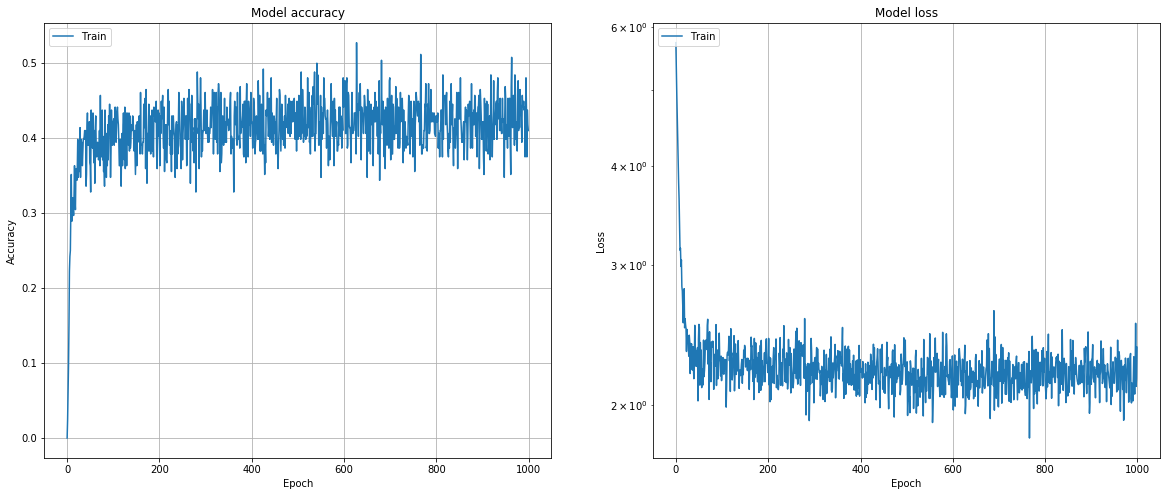

In [39]:
# Plot training & validation accuracy values
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(121)
plt.grid()
plt.plot(noisy_history.history['acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

# Plot training & validation loss values
ax = fig.add_subplot(122)
plt.grid()
plt.plot(noisy_history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.yscale('log')
# plt.subplots_adjust(wspace = 0.5)

In [40]:
r = hot_model.predict(np.array(receiver.block_coded_elements))
index = np.array(list(map(lambda x: np.argmax(x), r)))

print(index)
print(np.array(receiver.block_elements)[index])

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [0]:
hot_model.save('map_without_noise.h5')

In [0]:
EsN0Dbs